<a href="https://colab.research.google.com/github/CodeByGui-hub/ml-projects/blob/main/metricas_avaliacao_desempenho/metricas_avalizacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **instalando bibliotecas e dependências**

In [1]:
!pip install tensorflow
!pip install --upgrade matplotlib
!pip install --upgrade scikit-learn

In [2]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
from sklearn.metrics import RocCurveDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import cycle

# **Carregamento e Pré-processamento dos Dados**

In [3]:
# Carrega o dataset MNIST e separa em treino e teste
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Ajusta o formato das imagens para (amostras, altura, largura, canais)
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normaliza os valores de pixel para o intervalo [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define explicitamente as classes do problema (dígitos de 0 a 9)
classes = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).astype('uint8')

# **Construção e treinamento do modelo**

In [4]:
# Criação de um modelo sequencial
model = models.Sequential()

# Definindo as camadas convolucionais
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))

# Camada de achatamento para converter mapas de características em vetor
model.add(layers.Flatten())

# Camada densa intermediária para combinação das características extraídas
model.add(layers.Dense(64, activation = 'relu'))

# Camada de saída:
model.add(layers.Dense(10, activation = 'softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Compila o modelo definindo o processo de otimização
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

# Treina o modelo
model.fit(
    train_images,
    train_labels,
    epochs = 5,
    validation_data = (test_images, test_labels)
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.8958 - loss: 0.3320 - val_accuracy: 0.9845 - val_loss: 0.0458
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 68s 29ms/step - accuracy: 0.9837 - loss: 0.0500 - val_accuracy: 0.9821 - val_loss: 0.0594
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - accuracy: 0.9896 - loss: 0.0341 - val_accuracy: 0.9859 - val_loss: 0.0447
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 54s 29ms/step - accuracy: 0.9921 - loss: 0.0245 - val_accuracy: 0.9852 - val_loss: 0.0463
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - accuracy: 0.9936 - loss: 0.0192 - val_accuracy: 0.9929 - val_loss: 0.0223


In [6]:
# Rótulos verdadeiros do conjunto de teste
y_true = test_labels

# Predição do modelo sobre os dados de teste
probabilities = model.predict(test_images)

# Conversão das probabilidades em rótulos preditos
y_pred = np.argmax(probabilities, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


# **Matriz de confusão**

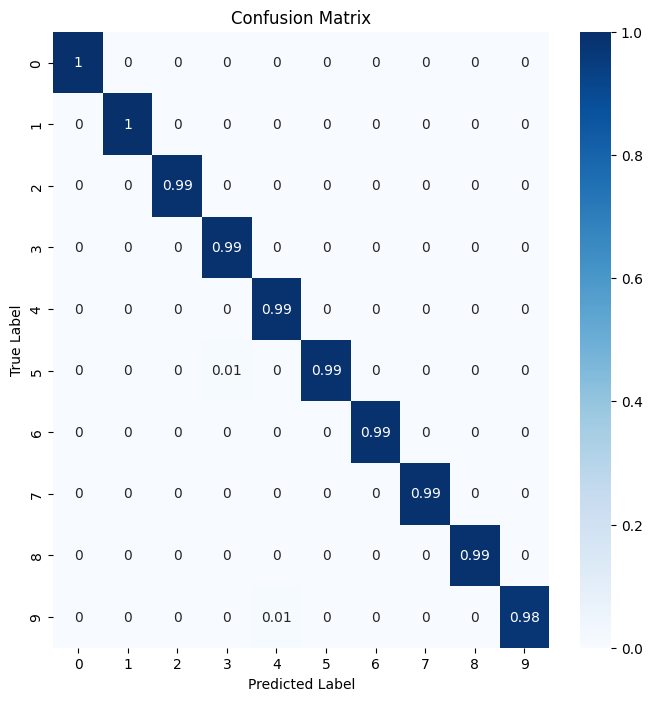

In [7]:
# Cálculo da matriz de confusão
conf_mat = tf.math.confusion_matrix(
    labels = test_labels,
    predictions = y_pred
).numpy()

# Normalização da matriz de confusão por classe verdadeira
conf_mat_norm = np.around(
    conf_mat.astype('float') / conf_mat.sum(axis = 1)[:, np.newaxis],
    decimals = 2
)

# Conversão para DataFrame para facilitar visualização
conf_mat_df = pd.DataFrame(
    conf_mat_norm,
    index = classes,
    columns = classes
)

# Criação do gráfico da matriz de confusão
plt.figure(figsize = (8, 8))
sns.heatmap(conf_mat_df, annot = True, cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# **Função de Cálculo e plot das métricas de avaliação**

In [8]:
# Binariza os rótulos verdadeiros para cada classe
y_true_bin = label_binarize(y_true, classes = classes)

# Define os scores contínuos previstos pelo modelo
y_score = probabilities

# Cria lista de nomes das classes para visualização
target_names = [str(c) for c in classes]

In [9]:
# Classe para avaliação de desempenho de modelos de classificação multiclasse.
class ModelAssessment():

  # Inicializando a classe com os dados necessários para avaliação.
  def __init__(self, y_true, y_pred, y_score, y_true_bin, classes):

    self.y_true = y_true
    self.y_pred = y_pred
    self.y_score = y_score
    self.y_true_bin = y_true_bin
    self.classes = classes

  # Função para o cálculo das métricas de avaliação
  def calculate_metrics(self, confusion_matrix):

    num_classes = len(self.classes)

    # Listas para armazenar métricas por classe
    accuracy_list = []
    recall_list = []
    precision_list = []
    specificity_list = []
    f1_score_list = []
    support_list = []

    # Cálculo das métricas para cada classe
    for i in range(num_classes):
      vp = confusion_matrix[i, i]
      fp = confusion_matrix[:, i].sum() - vp
      fn = confusion_matrix[i, :].sum() - vp
      vn = confusion_matrix.sum() - vp - fp - fn

      accuracy = (vp + vn) / confusion_matrix.sum()
      recall = vp / (vp + fn) if (vp + fn) > 0 else 0
      precision = vp / (vp + fp) if (vp +fp) > 0 else 0
      specificity = vn / (fp + vn) if (fp + vn) > 0 else 0
      f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
      support_i = vp + fn

      # Adiciona métricas às listas
      support_list.append(support_i)
      accuracy_list.append(accuracy)
      recall_list.append(recall)
      precision_list.append(precision)
      specificity_list.append(specificity)
      f1_score_list.append(f1_score)

    # Cria DataFrame com métricas detalhadas
    df = pd.DataFrame(
        {   'ACCURACY': accuracy_list,
            'RECALL': recall_list,
            'PRECISION': precision_list,
            'SPECIFICITY': specificity_list,
            'F1_SCORE': f1_score_list,
            'SUPPORT': support_list
        }, index=self.classes)

    df = df.style.set_properties(**{
        'text-align': 'center'
        }).format("{:.4f}").set_caption("Avaliação Detalhada do Modelo por Classe")

    # Cálculo de métricas agregadas
    vp_total = np.trace(confusion_matrix)
    total_samples = confusion_matrix.sum()
    micro_accuracy = vp_total / total_samples if total_samples > 0 else 0

    average_recall = np.average(recall_list, weights = support_list)
    average_precision = np.average(precision_list, weights = support_list)
    average_specificity = np.average(specificity_list, weights = support_list)
    average_f1_score = np.average(f1_score_list, weights = support_list)

    # DataFrame com resumo das métricas agregadas
    df1 = pd.DataFrame({
        'ACCURACY': accuracy,
        'MICRO_ACCURACY': micro_accuracy,
        'AVERAGE_RECALL': average_recall,
        'AVERAGE_PRECISION': average_precision,
        'AVERAGE_SPECIFICITY': average_specificity,
        'AVERAGE_F1_SCORE': average_f1_score
    }, index=[0])

    df1 = df1.style.set_properties(**{
        'text-align': 'center'
        }).format("{:.4f}").set_caption("Resumo Estatístico das Métricas (Micro/Weighted)")

    # Retorna os DataFrames estilizados
    return display(
        '------------------------------------------------------------------------------------------------------',
        df,
        '------------------------------------------------------------------------------------------------------',
        df1)

  # Função para Cálculo da curva ROC e AUC micro
  def micro_roc_auc(self):

    num_classes = len(self.classes)
    fpr_micro = dict()
    tpr_micro = dict()
    roc_auc_micro = dict()

    # Curva ROC micro-averaged
    fpr_micro["micro"], tpr_micro["micro"], _ = roc_curve(self.y_true_bin.ravel(), self.y_score.ravel())
    roc_auc_micro["micro"] = auc(fpr_micro["micro"], tpr_micro["micro"])

    print(f"Média Micro One-vs-Rest ROC AUC score:\n{roc_auc_micro['micro']:.2f}")

    return fpr_micro, tpr_micro, roc_auc_micro

  # Função para Cálculo da curva ROC e AUC macro
  def macro_roc_auc(self):

    num_classes = len(self.classes)
    fpr_macro = dict()
    tpr_macro = dict()
    roc_auc_macro = dict()

    # Curvas ROC individuais por classe
    for i in range(num_classes):
      fpr_macro[i], tpr_macro[i], _ = roc_curve(self.y_true_bin[:, i], self.y_score[:, i])
      roc_auc_macro[i] = auc(fpr_macro[i], tpr_macro[i])

    # Interpolação para calcular média macro
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(num_classes):
        mean_tpr += np.interp(fpr_grid, fpr_macro[i], tpr_macro[i])

    mean_tpr /= num_classes

    # Curva macro agregada
    fpr_macro["macro"] = fpr_grid
    tpr_macro["macro"] = mean_tpr
    roc_auc_macro["macro"] = auc(fpr_macro["macro"], tpr_macro["macro"])

    print(f"Média Macro One-vs-Rest ROC AUC score:\n{roc_auc_macro['macro']:.2f}")

    return fpr_macro, tpr_macro, roc_auc_macro

  # Plota as curvas ROC micro e macro por classe.
  def plot_roc(self, fpr_micro, tpr_micro, roc_auc_micro, fpr_macro, tpr_macro, roc_auc_macro):

    num_classes = len(self.classes)
    fig, ax = plt.subplots(figsize = (6, 6))

    # Curvas Micro
    ax.plot(
        fpr_micro['micro'],
        tpr_micro['micro'],
        label = f'Média Micro ROC Curve (AUC = {roc_auc_micro["micro"]:.2f})',
        color = 'deeppink',
        linestyle = ':',
        linewidth = 4,
    )

    # Curvas Macro
    ax.plot(
        fpr_macro['macro'],
        tpr_macro['macro'],
        label = f'Média Macro ROC Curve (AUC = {roc_auc_macro["macro"]:.2f})',
        color = 'navy',
        linestyle = ':',
        linewidth = 4,
    )

    # Curvas individuais por classe
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

    for class_id, color in zip(range(num_classes), colors):
      RocCurveDisplay.from_predictions(
          self.y_true_bin[:, class_id],
          self.y_score[:, class_id],
          name = f'Curva ROC da Classe {target_names[class_id]}',
          curve_kwargs=dict(color = color),
          ax = ax,
          plot_chance_level=(class_id == 1),
          despine = True,
      )

    # Configurações de labels e título
    ax.set_xlabel('Taxa de Falsos Positivos')
    ax.set_ylabel('Taxa de Verdadeiros Positivos')
    ax.set_title('Curva ROC (Receiver Operating Characteristic\nto One-vs-Rest multiclass)')

# **Visualização e comparação das métricas de avaliação**

In [10]:
# Cria uma instância da classe ModelAssessment e Chama o método calculate_metrics
calc = ModelAssessment(y_true, y_pred, y_score, y_true_bin, classes)
calc.calculate_metrics(conf_mat)

'------------------------------------------------------------------------------------------------------'

,ACCURACY,RECALL,PRECISION,SPECIFICITY,F1_SCORE,SUPPORT
0,0.9992,0.9969,0.9949,0.9994,0.9959,980.0000
1,0.9992,0.9991,0.9939,0.9992,0.9965,1135.0000
2,0.9989,0.9932,0.9961,0.9996,0.9947,1032.0000
3,0.9983,0.9931,0.9901,0.9989,0.9916,1010.0000
4,0.9985,0.9939,0.9909,0.9990,0.9924,982.0000
5,0.9983,0.9922,0.9888,0.9989,0.9905,892.0000
6,0.9988,0.9927,0.9948,0.9994,0.9937,958.0000
7,0.9984,0.9922,0.9922,0.9991,0.9922,1028.0000
8,0.9988,0.9949,0.9928,0.9992,0.9938,974.0000
9,0.9974,0.9802,0.9940,0.9993,0.9870,1009.0000


'------------------------------------------------------------------------------------------------------'

,ACCURACY,MICRO_ACCURACY,AVERAGE_RECALL,AVERAGE_PRECISION,AVERAGE_SPECIFICITY,AVERAGE_F1_SCORE
0,0.9974,0.9929,0.9929,0.9929,0.9992,0.9929


In [11]:
# Calcula as métricas de avaliação usando funções do scikit-learn para comparação
acuracia = accuracy_score(y_true, y_pred)
precisao = precision_score(y_true, y_pred, average='weighted')
revocacao = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Acurácia: {acuracia}')
print(f'Precisão: {precisao}')
print(f'Revocação: {revocacao}')
print(f'F1-Score: {f1}')

print('\nClassification Report:')
print(classification_report(y_true, y_pred))

Acurácia: 0.9929
Precisão: 0.9929045338933978
Revocação: 0.9929
F1-Score: 0.9928953995862432

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### **Média micro e macro One-vs-Rest ROC AUC score**

In [12]:
# Cria uma instância da classe ModelAssessment e Chama o método micro_roc_auc
micro_roc = ModelAssessment(y_true, y_pred, y_score, y_true_bin, classes)
fpr_micro, tpr_micro, roc_auc_micro = micro_roc.micro_roc_auc()

Média Micro One-vs-Rest ROC AUC score:
1.00


In [13]:
# Cria uma instância da classe ModelAssessment e Chama o método macro_roc_auc
macro_roc = ModelAssessment(y_true, y_pred, y_score, y_true_bin, classes)
fpr_macro, tpr_macro, roc_auc_macro = macro_roc.macro_roc_auc()

Média Macro One-vs-Rest ROC AUC score:
1.00


# **Visualização da Curva ROC e AUC**

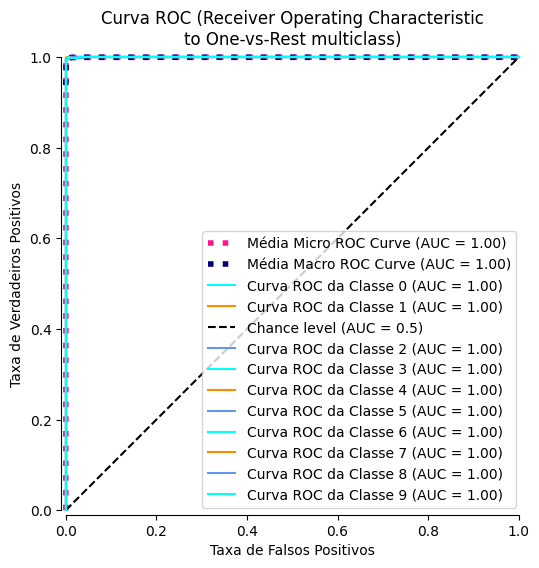

In [14]:
# Cria uma instância da classe ModelAssessment e Chama o método plot_roc
plot = ModelAssessment(y_true, y_pred, y_score, y_true_bin, classes)
plot.plot_roc(fpr_micro, tpr_micro, roc_auc_micro, fpr_macro, tpr_macro, roc_auc_macro)